# Autoencoder para quitar ruido de imagenes

Teniendo el dataset de MNIST, se hará un modelo que elimine ruido gausiano de las imagenes usando una red neuronal convolucional y usando la tecnica de Gradient Accumulation.

In [ ]:
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm.models.vision_transformer import VisionTransformer, PatchEmbed

Tenemos que el autoencoder:

1. **Codifica** la imagen de entrada (1 canal) con dos capas `Conv2d` que la **reducen** espacialmente (downsampling) y extraen 32 mapas de características, usando `ReLU`.
2. **Decodifica** ese “código” con dos capas `ConvTranspose2d` que **aumentan** de nuevo la resolución (upsampling) hasta restaurar 1 canal, también con `ReLU` y una `Sigmoid` final para asegurar que los píxeles queden en \[0,1].


In [ ]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x)
        return self.decoder(z)


Se descarga y prepara el dataset de MNIST. Tambien se define una funcion que agrega el ruido distribuido en una campana de gaus.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor()
])
train_ds = datasets.MNIST('.', train=True, download=True, transform=transform)
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True, pin_memory=torch.cuda.is_available())

def add_noise(x, noise_factor=0.4):
    return torch.clamp(x + noise_factor * torch.randn_like(x), 0., 1.)


Se usa Adam para optimizar la funcion de perdida MSE y acumulammos los gradientes en grupos de 4 batches, despues de computar un grupo se hace un paso de optimizacion de parametros.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DenoisingAutoencoder().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.MSELoss()

accum_steps = 4  # acumulamos gradientes de 4 batchs
optimizer.zero_grad()

for epoch in range(10):
    running_loss = 0.
    for i, (imgs, _) in enumerate(train_loader):
        imgs = imgs.to(device, non_blocking=True)
        noisy = add_noise(imgs).to(device)

        outputs = model(noisy)
        loss = criterion(outputs, imgs) / accum_steps
        loss.backward()

        if (i + 1) % accum_steps == 0:
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accum_steps

    print(f"Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}")


Epoch 1, Loss: 0.0575
Epoch 2, Loss: 0.0123
Epoch 3, Loss: 0.0107
Epoch 4, Loss: 0.0102
Epoch 5, Loss: 0.0100
Epoch 6, Loss: 0.0098
Epoch 7, Loss: 0.0097
Epoch 8, Loss: 0.0096
Epoch 9, Loss: 0.0095
Epoch 10, Loss: 0.0094


Ahora graficamos los resultados

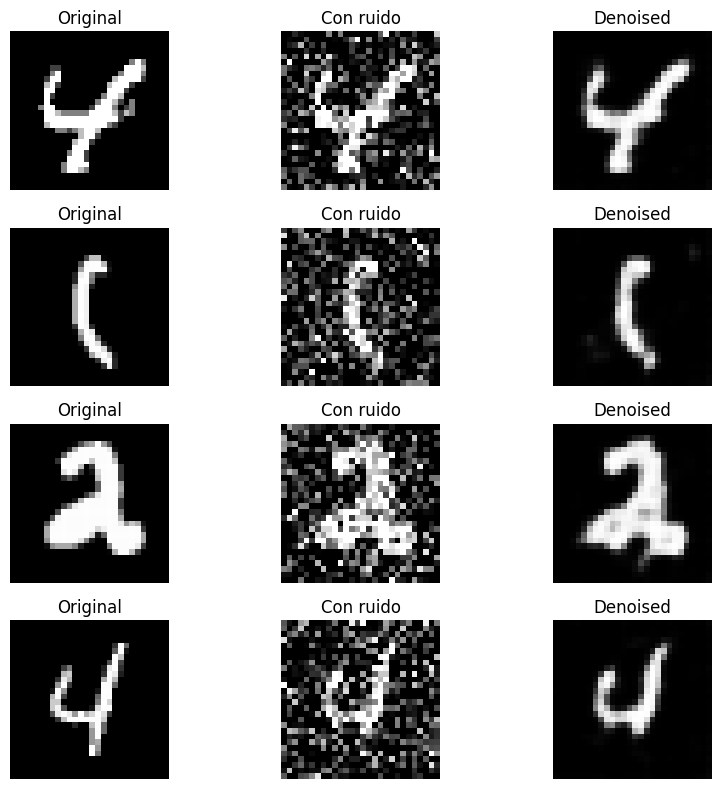

In [ ]:
import matplotlib.pyplot as plt

# Pasa al modo evaluación y desactiva el cálculo de gradientes
model.eval()
with torch.no_grad():
    imgs, _ = next(iter(train_loader))
    imgs = imgs.to(device)
    noisy = add_noise(imgs).to(device)
    outputs = model(noisy)

imgs = imgs.cpu().numpy()
noisy = noisy.cpu().numpy()
outputs = outputs.cpu().numpy()

# Graficamos las primeras N imágenes
N = 4
fig, axes = plt.subplots(N, 3, figsize=(9, 2*N))
for i in range(N):
    axes[i,0].imshow(imgs[i].squeeze(), cmap='gray')
    axes[i,0].set_title('Original')
    axes[i,0].axis('off')

    axes[i,1].imshow(noisy[i].squeeze(), cmap='gray')
    axes[i,1].set_title('Con ruido')
    axes[i,1].axis('off')

    axes[i,2].imshow(outputs[i].squeeze(), cmap='gray')
    axes[i,2].set_title('Denoised')
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()

# Vision Transformer

In [ ]:
# Nuevo tamaño de imagen
img_size = 28
patch_size = 4
in_chans = 1
num_classes = 10
embed_dim = 192
depth = 12
num_heads = 3
mlp_ratio = 4.0

# Transformaciones
vt_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Datasets y loaders
vt_train_ds = datasets.MNIST('.', train=True,  download=True, transform=vt_transform)
vt_val_ds   = datasets.MNIST('.', train=False, download=True, transform=vt_transform)
vt_train_loader = DataLoader(vt_train_ds, batch_size=64, shuffle=True)
vt_val_loader   = DataLoader(vt_val_ds,   batch_size=64)

# Modelo Vision Transformer con parámetros ajustados
vt_model = VisionTransformer(
    img_size=img_size,
    patch_size=patch_size,
    in_chans=in_chans,
    num_classes=num_classes,
    embed_dim=embed_dim,
    depth=depth,
    num_heads=num_heads,
    mlp_ratio=mlp_ratio,
    qkv_bias=True,
    norm_layer=nn.LayerNorm
).to(device)

# Optimización y pérdida
vt_optimizer = optim.AdamW(vt_model.parameters(), lr=1e-4, weight_decay=1e-4)
criterion = nn.CrossEntropyLoss()

# Entrenamiento
for epoch in range(5):
    vt_model.train()
    for imgs, labels in vt_train_loader:
        imgs = imgs.to(device, non_blocking=True)
        labels = labels.to(device, non_blocking=True)

        preds = vt_model(imgs)
        loss = criterion(preds, labels)

        vt_optimizer.zero_grad()
        loss.backward()
        vt_optimizer.step()

    print(f"Epoch {epoch+1} completa")

Epoch 1 completa
Epoch 2 completa
Epoch 3 completa
Epoch 4 completa
Epoch 5 completa


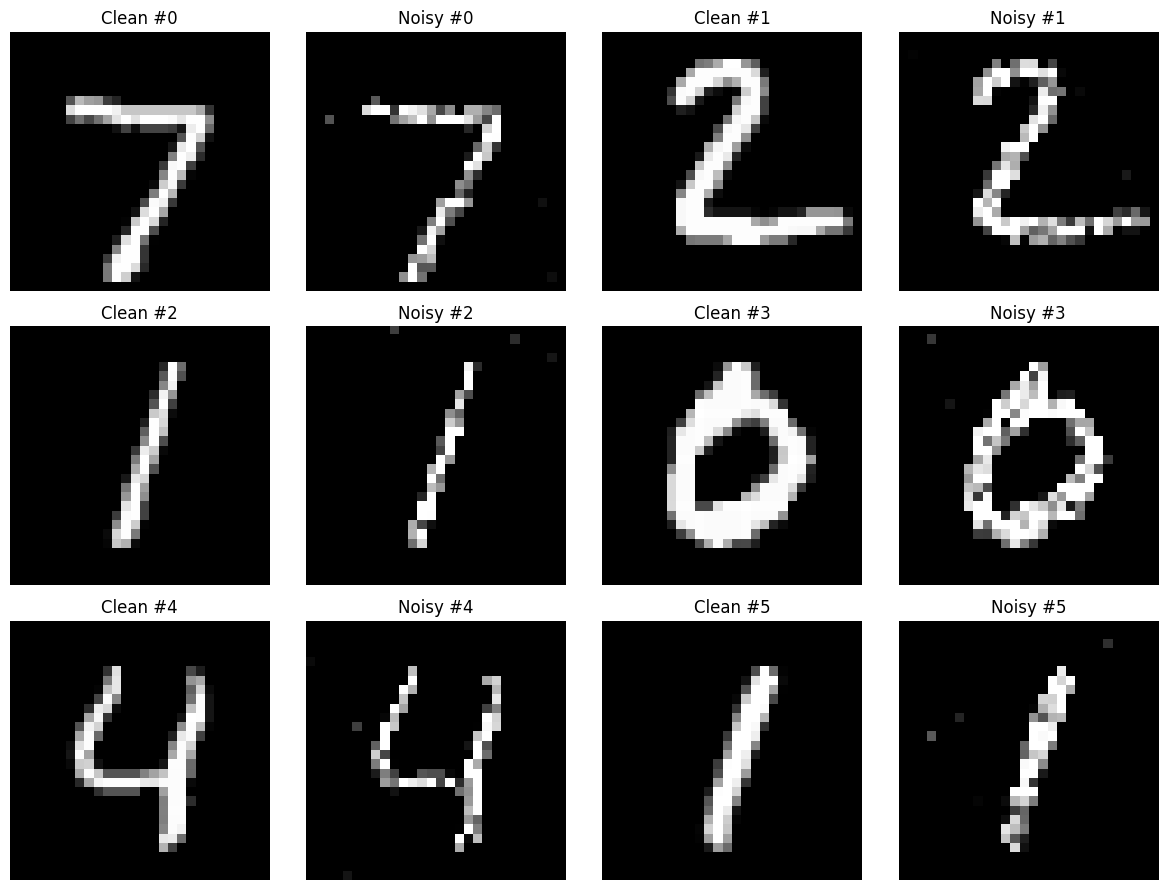

In [ ]:
imgs, _ = next(iter(vt_val_loader))   # tensores [B,1,224,224]
imgs = imgs.to(device)
noisy = add_noise(imgs)
imgs_np  = imgs.cpu().numpy()
noisy_np = noisy.cpu().numpy()

# Selecciona 6 índices para 3 filas (2 muestras por fila)
indices = [0, 1, 2, 3, 4, 5]

fig, axes = plt.subplots(3, 4, figsize=(12, 9))
for row in range(3):
    # parejas de este row: idx1, idx2
    idx1 = indices[2*row]
    idx2 = indices[2*row + 1]
    for col, idx in enumerate([idx1, idx2]):
        # clean en columna par, noisy en columna impar
        axes[row, 2*col].imshow(imgs_np[idx].squeeze(), cmap='gray')
        axes[row, 2*col].set_title(f"Clean #{idx}")
        axes[row, 2*col].axis('off')

        axes[row, 2*col + 1].imshow(noisy_np[idx].squeeze(), cmap='gray')
        axes[row, 2*col + 1].set_title(f"Noisy #{idx}")
        axes[row, 2*col + 1].axis('off')

plt.tight_layout()
plt.show()